In [121]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import rasterio
import geopandas as gpd
import matplotlib.cm as cm
from scipy.stats import chisquare
import pysal
from pysal.lib import weights
from pysal.explore import esda
from pysal.explore import pointpats
from skimage import exposure
import pointpats

from rasterio.plot import show


In [97]:
# Read in the data
df = pd.read_excel("FireScar_CL_Summary_1985-2018.xlsx")
regions = gpd.read_file("Regiones/Regional.shp")
# Fix CRS for regions
regions = regions.to_crs("EPSG:4326")
df = df[df['FireScar']==1] # filter to just files that have fire scar
df = df[df['Region_CONAF']=='Maule']

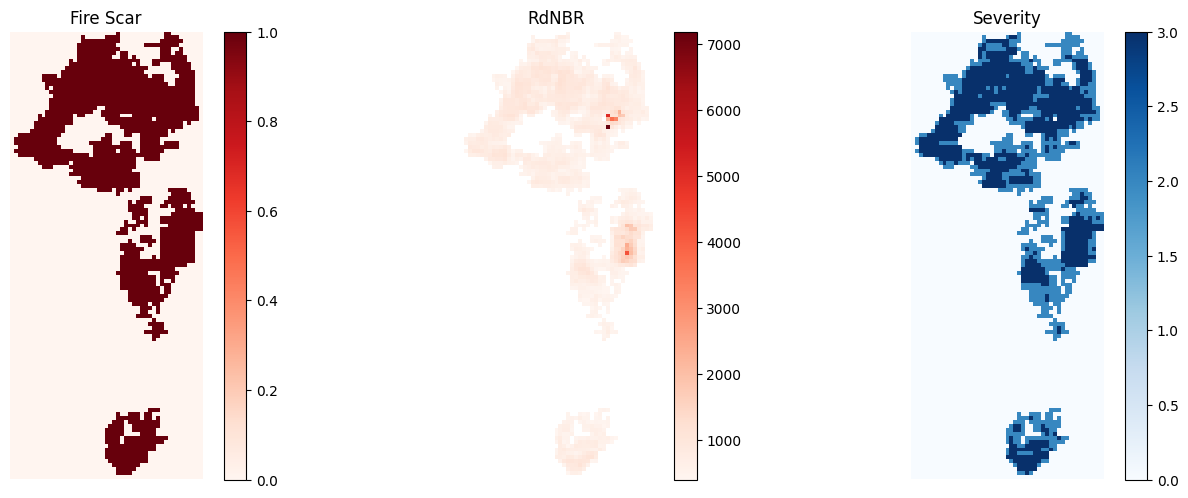

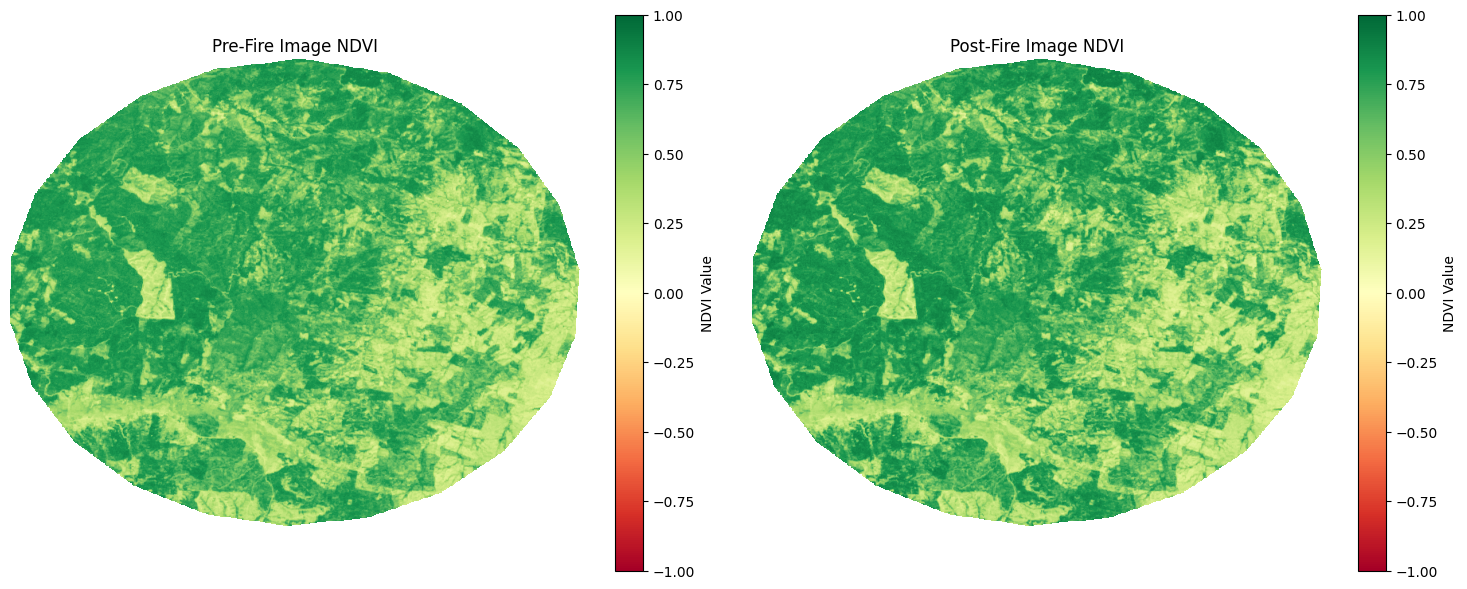

(-72.26874595518821,
 -72.07578783215934,
 -35.65440312128905,
 -35.49647929434084)

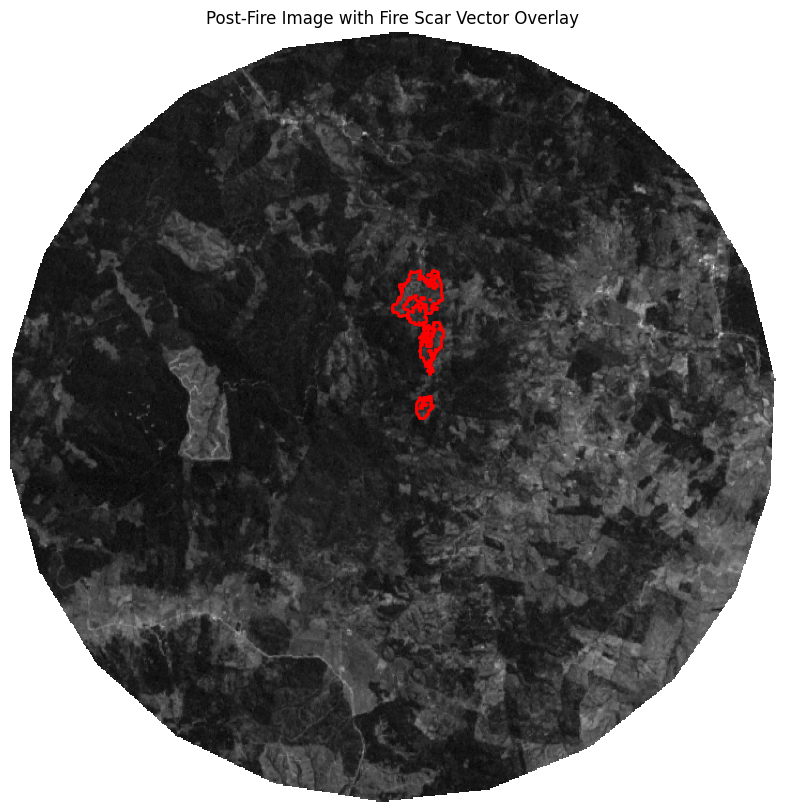

In [122]:

example_fire = df.iloc[1]  # You can choose a specific FireID instead

#  Extract relevant info
fire_season = example_fire["FireSeason"]
folder = f"Fire_CL-ML_Maule/FireScar_CL-ML_Maule_{fire_season}"
file_names = {
    "Fire Scar": (example_fire["FireScarImgName"], "Reds"),
    "RdNBR": (example_fire["RdNBRImgName"], "Reds"),
    "Severity": (example_fire["SeverityImgName"], "Blues"),
}

pre_fire_path = os.path.join(folder, example_fire["PreFireImgName"])
post_fire_path = os.path.join(folder, example_fire["PostFireImgName"])
fire_scar_path = os.path.join(folder, example_fire["FireScarVectorName"])

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (title, (file_name, cmap)) in zip(axes, file_names.items()):
    file_path = os.path.join(folder, file_name)
    
    if os.path.exists(file_path):
        with rasterio.open(file_path) as src:
            img = src.read(1)  # Read first band
            im = ax.imshow(img, cmap=cmap)
            ax.set_title(title, fontsize=12)
            ax.axis("off")
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Add colorbar
    else:
        ax.set_title(f"{title}\n(File Not Found)", fontsize=12)
        ax.axis("off")

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Pre-Fire NDVI Plot
with rasterio.open(pre_fire_path) as src:
    # Read the NDVI band (assumed to be band 7)
    ndvi = src.read(7)
    
    # Plot the NDVI using the "RdYlGn" color map
    img = axes[0].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[0].set_title('Pre-Fire Image NDVI')
    axes[0].axis('off')  # Turn off axis
    plt.colorbar(img, ax=axes[0], label='NDVI Value')  # Add a color bar

# Post-Fire NDVI Plot
with rasterio.open(post_fire_path) as src:
    # Read the NDVI band (assumed to be band 7)
    ndvi = src.read(7)
    
    # Plot the NDVI using the "RdYlGn" color map
    img = axes[1].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[1].set_title('Post-Fire Image NDVI')
    axes[1].axis('off')  # Turn off axis
    
    # Load the fire scar vector shapefile using geopandas
    #fire_scar_gdf = gpd.read_file(fire_scar_path)
    
    # Plot the fire scar polygons on top of the NDVI plot
    #fire_scar_gdf.plot(ax=axes[1], facecolor='none', edgecolor='red', linewidth=2)  # Red edge for fire scar polygons
    
    # Add a color bar for the Post-Fire NDVI plot
    plt.colorbar(img, ax=axes[1], label='NDVI Value')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

with rasterio.open(post_fire_path) as src:
    # Set up the plot and show the post-fire image as the background
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src, ax=ax, cmap='gray')  # Plot post-fire image

# Load the fire scar vector shapefile using geopandas
fire_scar_gdf = gpd.read_file(fire_scar_path)

# Plot the fire scar polygons on top of the post-fire image
fire_scar_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)  # Red edges for the fire scar polygons

# Add a title and hide the axes for a cleaner look
ax.set_title('Post-Fire Image with Fire Scar Vector Overlay')
ax.axis('off')
